# Handwritten Digit Recognizer

注意：このノートブックはGPUの有無に関わらずPython 3.x および　TensorFlow 2.x（ないしTensorFlow 1.x） にて、オフラインにて稼動するよう変更しています。<br>
Google Colab環境にてオンラインで実行する場合、オリジナルサイトのコードを使って下さい。<br>
2020/02/04: By H.Nishiyama<br>
2021/11/23 追加・変更、コメントの日本語化<br>
2023/04/16 このコードを実行する前に、「1. MNIST double layer CNN classification.ipynb」を実行し、「MNIST_double.hd5」を所定の場所に保存しておく必要があります。<br>
このノートブックはTensorFlow 2.x (ないし1.x）を使います<br>
**2024/06/29 １年ほど前からローカル環境ではJavascriptで記述されたHTML-Canvasからの画像データ（image）をPython側にて受け取ることができなくなっています。（原因については未確認）**<br>
従いまして<br>
1. MNIST double layer CNN classification.ipynb<br>
2. Handwritten digit recognizer.ipynb<br>
については（コメント箇所を書き換えて）colaboratoryでの利用を願います。あるいは下記のオリジナルサイトでのバージンにて利用願います。<br>
【オリジナルサイト】https://github.com/enakai00/colab_tfbook

In [1]:
###%tensorflow_version 2.x

#### [HDR-01]
Import modules.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models

#### [HDR-02]
Modified to local (off-line) system.<br>
Original: Mount your Google Drive on `/content/gdrive`.<br>
Modified: Nothing.

In [3]:
###from google.colab import drive
###drive.mount('/content/gdrive')

#### [HDR-03]

`MNIST_double.hd5` were already made at "1. MNIST double layer CNN classification.ipynb."
Modified to local (off-line) system.<br>
Original: Confirm that the exported model file `MNIST_double.hd5` is on your Google Drive.<br>
Modified: Confirm that the exported model file MNIST_double.hd5 is on your c:\tmp\ directory.

In [4]:
###!ls -lh '/content/gdrive/My Drive/MNIST_double.hd5'
# For local (off-line) mode, use /tmp/ dir.
# If you use on online-colaboratory system, comment out the next line.
!dir \tmp\MNIST_double.hd5

 ドライブ C のボリューム ラベルがありません。
 ボリューム シリアル番号は 406A-B97E です

 c:\tmp のディレクトリ

2021/11/18  18:47        39,343,920 MNIST_double.hd5
               1 個のファイル          39,343,920 バイト
               0 個のディレクトリ  685,885,091,840 バイトの空き領域


#### [HDR-04]
Restore the model from the exported model file.<br>
Modified to local (off-line) system.<br>
*Waring will be occured for some version of TensorFlow as follows;<br>
WARNING:tensorflow:From ...

In [5]:
###model = models.load_model('/content/gdrive/My Drive/MNIST_double.hd5')
# For local (off-line) mode, use /tmp/ dir.
# If you use on online-colaboratory system, comment out the next line.
model = models.load_model('/tmp/MNIST_double.hd5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv_filter1 (Conv2D)        (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling1 (MaxPooling2D)  (None, 14, 14, 32)        0         
_________________________________________________________________
conv_filter2 (Conv2D)        (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2 (MaxPooling2D)  (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
hidden (Dense)               (None, 1024)              3

#### [HDR-05]
Define a model to extract outputs from intermediate layers.

In [6]:
layer_outputs = [model.get_layer('max_pooling1').output,
                 model.get_layer('max_pooling2').output]
model2 = models.Model(inputs=model.input, outputs=layer_outputs)

#### [HDR-06]
Define a Javascript function to create a drawing canvas.<br>
*Modified to local (off-line) system.<br>

In [7]:
input_form = """
<table>
<td style="border-style: none;">
<div style="border: solid 2px #666; width: 143px; height: 144px;">
<canvas width="140" height="140"></canvas>
</div></td>
<td style="border-style: none;">
<button onclick="clear_value()">Clear</button>
</td>
</table>
"""

javascript = """
<script type="text/Javascript">
    var pixels = [];
    for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    var click = 0;

    var canvas = document.querySelector("canvas");
    canvas.addEventListener("mousemove", function(e) {
        if (e.buttons == 1) {
            click = 1;
            canvas.getContext("2d").fillStyle = "rgb(0, 0, 0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 8, 8);
            x = Math.floor(e.offsetY*0.2);
            y = Math.floor(e.offsetX*0.2) + 1;
            for (var dy = 0; dy < 2; dy++) {
                for (var dx = 0; dx < 2; dx++) {
                    if ((x + dx < 28) && (y + dy < 28)) {
                        pixels[(y+dy)+(x+dx)*28] = 1;
                    }
                }
            }
        } else {
            if (click == 1) set_value()
            click = 0;
        }
    });
    
    function set_value() {
        var result = "";
        for (var i = 0; i < 28*28; i++) result += pixels[i] + ",";
        
        //--- If you use original online-colaboratory system,
        //    remove "////" from the beginning of the next two lines.
        //// google.colab.kernel.invokeFunction(
        ////                  'notebook.set_image', [result], {});
        
        //--- If you use original online-colaboratory system,
        //    add "////" to the beginning of the next two lines.
        var kernel = IPython.notebook.kernel;
        kernel.execute("image = [" + result + "]");
    }

    function clear_value() {
        canvas.getContext("2d").fillStyle = "rgb(255, 255, 255)";
        canvas.getContext("2d").fillRect(0, 0, 140, 140);
        for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    }
</script>
"""

#### [HDR-07]
Show a drawing canvas.

In [8]:
###from google.colab import output  
from IPython.display import HTML

def set_image(result):
    global image
    image = np.array([float(x) for x in result.split(',')[:-1]])

image = None
###output.register_callback('notebook.set_image', set_image)

HTML(input_form + javascript)
# After appearing the Box for drawing...
# ↓　↓　↓　Please Draw number with pointing device such as mouse, then Run the cells below.

### Display the imput image (added to original code)

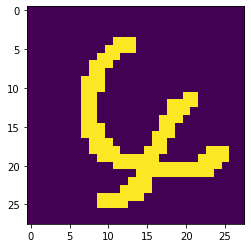

In [12]:
img = np.array(image).reshape((28,28))
plt.imshow(img)

#### [HDR-08]
Make a prediction for the handwritten digit on the drawing canvas.<br>
*Modified to local (off-line) system.<br>

<BarContainer object of 10 artists>

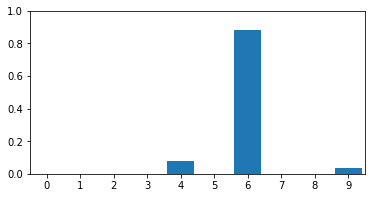

In [13]:
# If you use on online-colaboratory system, comment out the next line.
image = np.array(image, np.float16)
#---
p_val = model.predict(image.reshape(1,28*28))

fig = plt.figure(figsize=(6, 3))
pred = p_val[0]
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xticks(range(10))
subplot.set_xlim(-0.5, 9.5)
subplot.set_ylim(0, 1)
subplot.bar(range(10), pred, align='center')

#### [HDR-09]
Get output images from the convolutional filters.

In [14]:
pool1_output, pool2_output = model2.predict(image.reshape(1, 28*28))

#### [HDR-10]
Show output images from the first pooling layer.

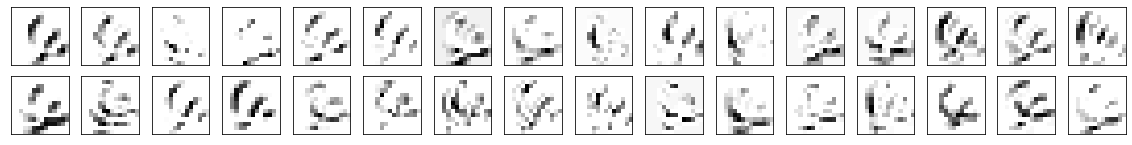

In [15]:
layer = pool1_output
fig = plt.figure(figsize=(20, 10))
for i in range(layer.shape[-1]):
    subplot = fig.add_subplot(8, 16, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(layer[0, :, :, i], cmap=plt.cm.gray_r)

#### [HDR-11]
Show output images from the second pooling layer.

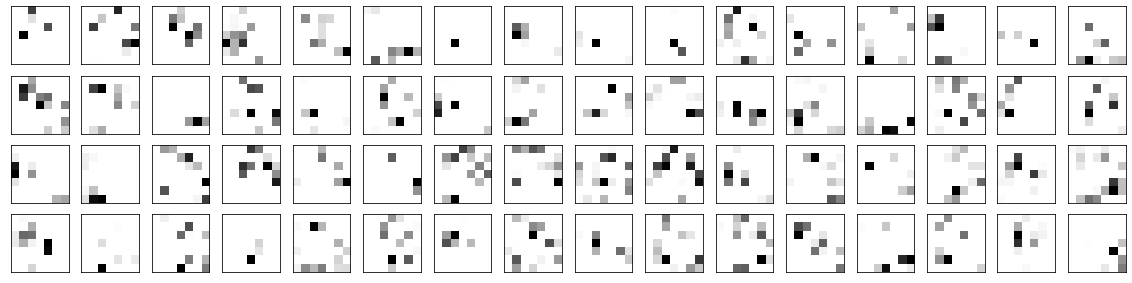

In [16]:
layer = pool2_output
fig = plt.figure(figsize=(20, 10))
for i in range(layer.shape[-1]):
    subplot = fig.add_subplot(8, 16, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(layer[0, :, :, i], cmap=plt.cm.gray_r)